In [38]:
import numpy as np
import pandas as pd
import datatable as dt
import time
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import seaborn as sns
from IPython.core.display import HTML, SVG
import IPython 
from ipywidgets import Layout
from ipywidgets import widgets
from IPython.display import display
from matplotlib import pyplot as plt
from plotly import graph_objs as go
from matplotlib.gridspec import GridSpec
plt.style.use('seaborn')

from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn import pipeline
from sklearn.pipeline import *
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import *
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostClassifier

# Encoder
import category_encoders
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder


# Home made
from cmougan import *
from featgen_transformers import *

In [39]:
accidents = pd.read_csv('Dataset & booklet/accidents.csv')
vehicles = pd.read_csv('Dataset & booklet/vehicles.csv')
test = pd.read_csv('Dataset & booklet/test.csv')

import pandas_profiling

profile = pandas_profiling.ProfileReport(accidents)
profile.to_file('accidents.html')


profile = pandas_profiling.ProfileReport(vehicles)
profile.to_file('vehicles.html')


profile = pandas_profiling.ProfileReport(test)
profile.to_file('test.html')


# OJO

In [40]:
accidents.shape

(137599, 30)

In [41]:
len(accidents.accident_id.unique())

136575

In [42]:
test.shape

(129950, 29)

In [43]:
len(test.accident_id.unique())

129950

NO SE QUE SIGNIFICA ESTO

# Split

In [44]:
train= accidents.set_index('accident_id').join(vehicles,on='accident_id')


In [45]:
test = test.set_index('accident_id').join(vehicles,on='accident_id')

In [46]:
train['train'] = 1
test['train']  = 0

In [47]:
df = train.append(test)

/Users/cmougan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




Encoding

In [48]:
# Reduce memory with kaggle function
df = reduce_mem_usage(df)

Memory usage of dataframe is 108.19 MB
Memory usage after optimization is: 23.81 MB
Decreased by 78.0%


### LSOA Feature
A Lower Layer Super Output Area (LSOA) is a GEOGRAPHIC AREA.

Lower Layer Super Output Areas are a geographic hierarchy designed to improve the reporting of small area statistics in England and Wales.

In [54]:
df.lsoa_of_accident_location.unique()

[E01000543, E01000375, E01033725, E01003379, E01002583, ..., W01000499, W01000432, W01001902, W01000461, W01000476]
Length: 32201
Categories (32201, object): [E01000543, E01000375, E01033725, E01003379, ..., W01000432, W01001902, W01000461, W01000476]

In [58]:
df.lsoa_of_accident_location.map(lambda x: "{:05}".format(x)[:2])

NameError: name 'rjust' is not defined

# Adversarial Trainning

In [22]:
from sklearn.utils import shuffle
df = shuffle(df)

In [ ]:
# Erase date
df = df.drop(columns='date')

# Split back
train = df[df['train']==1]
test = df[df['train']==0]
train = train.drop(columns='train')
test = test.drop(columns=['train','target'])


In [23]:
cbe = Encodings(encoding_type="CatBoostEncoder")
cbe.fit(train.drop(columns='target'),train.target)
df = cbe.transform(df)

In [24]:
X_tr, X_te, y_tr, y_te = sklearn.model_selection.train_test_split(df.drop(columns=['train','target']),df.train,random_state=1)

In [25]:
cb = CatBoostClassifier(iterations=300)
cbe = Encodings(encoding_type="CatBoostEncoder")
pipe_cb = Pipeline([
    ('selector', TypeSelector(np.number)),   
    ('cb',cb)])



pipeline_grid = {
    "cb__depth": [None]
        }

In [26]:
# Execution Hyperparameters
n_jobs=1
cv = 3
n_max= 2_000
pipe_cv = GridSearchCV(pipe_cb, param_grid=pipeline_grid, n_jobs = n_jobs, cv=cv,scoring='roc_auc')


In [27]:
pipe_cv, pipe_best_estimator  = fit_cv_subsample(pipe_cv, X_tr, y_tr, n_max = n_max);

Learning rate set to 0.05313
0:	learn: 0.6908622	total: 68ms	remaining: 20.3s
1:	learn: 0.6891030	total: 76ms	remaining: 11.3s
2:	learn: 0.6871920	total: 82.6ms	remaining: 8.17s
3:	learn: 0.6850439	total: 89.6ms	remaining: 6.63s
4:	learn: 0.6831878	total: 97ms	remaining: 5.72s
5:	learn: 0.6819304	total: 104ms	remaining: 5.07s
6:	learn: 0.6791100	total: 110ms	remaining: 4.62s
7:	learn: 0.6764073	total: 117ms	remaining: 4.27s
8:	learn: 0.6740774	total: 124ms	remaining: 4s
9:	learn: 0.6731687	total: 130ms	remaining: 3.78s
10:	learn: 0.6719223	total: 137ms	remaining: 3.59s
11:	learn: 0.6708136	total: 143ms	remaining: 3.44s
12:	learn: 0.6700385	total: 150ms	remaining: 3.3s
13:	learn: 0.6682586	total: 157ms	remaining: 3.21s
14:	learn: 0.6652556	total: 165ms	remaining: 3.13s
15:	learn: 0.6637057	total: 174ms	remaining: 3.09s
16:	learn: 0.6619263	total: 187ms	remaining: 3.12s
17:	learn: 0.6602585	total: 206ms	remaining: 3.23s
18:	learn: 0.6583292	total: 220ms	remaining: 3.25s
19:	learn: 0.6557

166:	learn: 0.4703764	total: 1.41s	remaining: 1.13s
167:	learn: 0.4695820	total: 1.43s	remaining: 1.12s
168:	learn: 0.4691143	total: 1.43s	remaining: 1.11s
169:	learn: 0.4680809	total: 1.44s	remaining: 1.1s
170:	learn: 0.4668685	total: 1.45s	remaining: 1.09s
171:	learn: 0.4646172	total: 1.45s	remaining: 1.08s
172:	learn: 0.4634007	total: 1.46s	remaining: 1.07s
173:	learn: 0.4616585	total: 1.47s	remaining: 1.06s
174:	learn: 0.4601324	total: 1.47s	remaining: 1.05s
175:	learn: 0.4593404	total: 1.48s	remaining: 1.04s
176:	learn: 0.4588437	total: 1.49s	remaining: 1.03s
177:	learn: 0.4573354	total: 1.49s	remaining: 1.02s
178:	learn: 0.4556793	total: 1.5s	remaining: 1.01s
179:	learn: 0.4540147	total: 1.51s	remaining: 1s
180:	learn: 0.4530023	total: 1.51s	remaining: 995ms
181:	learn: 0.4516747	total: 1.52s	remaining: 985ms
182:	learn: 0.4503229	total: 1.53s	remaining: 976ms
183:	learn: 0.4485028	total: 1.53s	remaining: 967ms
184:	learn: 0.4477251	total: 1.54s	remaining: 957ms
185:	learn: 0.446

41:	learn: 0.6232541	total: 302ms	remaining: 1.85s
42:	learn: 0.6218944	total: 315ms	remaining: 1.88s
43:	learn: 0.6203875	total: 324ms	remaining: 1.89s
44:	learn: 0.6194935	total: 331ms	remaining: 1.88s
45:	learn: 0.6182579	total: 338ms	remaining: 1.86s
46:	learn: 0.6161314	total: 344ms	remaining: 1.85s
47:	learn: 0.6140281	total: 352ms	remaining: 1.85s
48:	learn: 0.6120000	total: 359ms	remaining: 1.84s
49:	learn: 0.6111383	total: 366ms	remaining: 1.83s
50:	learn: 0.6094411	total: 373ms	remaining: 1.82s
51:	learn: 0.6069970	total: 380ms	remaining: 1.81s
52:	learn: 0.6059455	total: 386ms	remaining: 1.8s
53:	learn: 0.6043030	total: 394ms	remaining: 1.79s
54:	learn: 0.6029953	total: 401ms	remaining: 1.79s
55:	learn: 0.6011546	total: 409ms	remaining: 1.78s
56:	learn: 0.6001764	total: 416ms	remaining: 1.77s
57:	learn: 0.5987174	total: 423ms	remaining: 1.76s
58:	learn: 0.5978880	total: 429ms	remaining: 1.75s
59:	learn: 0.5965172	total: 440ms	remaining: 1.76s
60:	learn: 0.5955567	total: 451m

201:	learn: 0.4242781	total: 1.52s	remaining: 739ms
202:	learn: 0.4232577	total: 1.53s	remaining: 733ms
203:	learn: 0.4221907	total: 1.54s	remaining: 725ms
204:	learn: 0.4210317	total: 1.55s	remaining: 719ms
205:	learn: 0.4194774	total: 1.56s	remaining: 711ms
206:	learn: 0.4184461	total: 1.56s	remaining: 703ms
207:	learn: 0.4175892	total: 1.57s	remaining: 695ms
208:	learn: 0.4168507	total: 1.58s	remaining: 687ms
209:	learn: 0.4158847	total: 1.58s	remaining: 679ms
210:	learn: 0.4150505	total: 1.59s	remaining: 671ms
211:	learn: 0.4139650	total: 1.6s	remaining: 663ms
212:	learn: 0.4131210	total: 1.6s	remaining: 655ms
213:	learn: 0.4116783	total: 1.61s	remaining: 648ms
214:	learn: 0.4106956	total: 1.62s	remaining: 640ms
215:	learn: 0.4095335	total: 1.63s	remaining: 632ms
216:	learn: 0.4082411	total: 1.63s	remaining: 624ms
217:	learn: 0.4072698	total: 1.64s	remaining: 617ms
218:	learn: 0.4059609	total: 1.65s	remaining: 609ms
219:	learn: 0.4046563	total: 1.65s	remaining: 601ms
220:	learn: 0.

83:	learn: 0.5676282	total: 622ms	remaining: 1.6s
84:	learn: 0.5662011	total: 634ms	remaining: 1.6s
85:	learn: 0.5650580	total: 644ms	remaining: 1.6s
86:	learn: 0.5638174	total: 650ms	remaining: 1.59s
87:	learn: 0.5620931	total: 657ms	remaining: 1.58s
88:	learn: 0.5615399	total: 664ms	remaining: 1.57s
89:	learn: 0.5599586	total: 671ms	remaining: 1.56s
90:	learn: 0.5594131	total: 677ms	remaining: 1.55s
91:	learn: 0.5581312	total: 684ms	remaining: 1.54s
92:	learn: 0.5567101	total: 690ms	remaining: 1.53s
93:	learn: 0.5558857	total: 696ms	remaining: 1.53s
94:	learn: 0.5545925	total: 703ms	remaining: 1.52s
95:	learn: 0.5536483	total: 709ms	remaining: 1.51s
96:	learn: 0.5518581	total: 716ms	remaining: 1.5s
97:	learn: 0.5514857	total: 722ms	remaining: 1.49s
98:	learn: 0.5504716	total: 728ms	remaining: 1.48s
99:	learn: 0.5483163	total: 735ms	remaining: 1.47s
100:	learn: 0.5476804	total: 741ms	remaining: 1.46s
101:	learn: 0.5468439	total: 751ms	remaining: 1.46s
102:	learn: 0.5459107	total: 761m

261:	learn: 0.3715775	total: 1.83s	remaining: 266ms
262:	learn: 0.3697465	total: 1.84s	remaining: 259ms
263:	learn: 0.3690479	total: 1.85s	remaining: 252ms
264:	learn: 0.3678059	total: 1.86s	remaining: 245ms
265:	learn: 0.3667307	total: 1.86s	remaining: 238ms
266:	learn: 0.3662447	total: 1.87s	remaining: 231ms
267:	learn: 0.3649429	total: 1.88s	remaining: 224ms
268:	learn: 0.3644572	total: 1.88s	remaining: 217ms
269:	learn: 0.3633045	total: 1.89s	remaining: 210ms
270:	learn: 0.3624304	total: 1.9s	remaining: 203ms
271:	learn: 0.3617127	total: 1.9s	remaining: 196ms
272:	learn: 0.3606156	total: 1.91s	remaining: 189ms
273:	learn: 0.3601364	total: 1.92s	remaining: 182ms
274:	learn: 0.3590309	total: 1.92s	remaining: 175ms
275:	learn: 0.3579844	total: 1.93s	remaining: 168ms
276:	learn: 0.3569882	total: 1.94s	remaining: 161ms
277:	learn: 0.3559181	total: 1.94s	remaining: 154ms
278:	learn: 0.3551432	total: 1.95s	remaining: 147ms
279:	learn: 0.3544329	total: 1.95s	remaining: 140ms
280:	learn: 0.

129:	learn: 0.5454728	total: 1.1s	remaining: 1.44s
130:	learn: 0.5446208	total: 1.11s	remaining: 1.43s
131:	learn: 0.5439589	total: 1.12s	remaining: 1.43s
132:	learn: 0.5425374	total: 1.13s	remaining: 1.41s
133:	learn: 0.5412854	total: 1.13s	remaining: 1.41s
134:	learn: 0.5397611	total: 1.14s	remaining: 1.4s
135:	learn: 0.5382967	total: 1.15s	remaining: 1.39s
136:	learn: 0.5380070	total: 1.16s	remaining: 1.37s
137:	learn: 0.5369820	total: 1.16s	remaining: 1.36s
138:	learn: 0.5360082	total: 1.17s	remaining: 1.35s
139:	learn: 0.5348063	total: 1.18s	remaining: 1.34s
140:	learn: 0.5340247	total: 1.18s	remaining: 1.33s
141:	learn: 0.5325466	total: 1.19s	remaining: 1.32s
142:	learn: 0.5316469	total: 1.2s	remaining: 1.31s
143:	learn: 0.5304293	total: 1.2s	remaining: 1.3s
144:	learn: 0.5290856	total: 1.21s	remaining: 1.29s
145:	learn: 0.5279390	total: 1.22s	remaining: 1.28s
146:	learn: 0.5268975	total: 1.23s	remaining: 1.27s
147:	learn: 0.5259525	total: 1.23s	remaining: 1.26s
148:	learn: 0.525

In [28]:
pd.DataFrame(pipe_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cb__depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.373888,0.170714,0.019607,0.000663,None,{'cb__depth': None},0.542184,0.533114,0.505899,0.527076,0.015415,1


In [29]:
pipe_best_estimator.fit(X_tr,y_tr);

Learning rate set to 0.220062
0:	learn: 0.6862190	total: 57.5ms	remaining: 17.2s
1:	learn: 0.6806453	total: 122ms	remaining: 18.2s
2:	learn: 0.6762824	total: 185ms	remaining: 18.3s
3:	learn: 0.6745917	total: 276ms	remaining: 20.4s
4:	learn: 0.6717802	total: 352ms	remaining: 20.8s
5:	learn: 0.6698661	total: 421ms	remaining: 20.6s
6:	learn: 0.6688277	total: 477ms	remaining: 20s
7:	learn: 0.6678331	total: 550ms	remaining: 20.1s
8:	learn: 0.6667712	total: 606ms	remaining: 19.6s
9:	learn: 0.6662420	total: 667ms	remaining: 19.3s
10:	learn: 0.6651567	total: 767ms	remaining: 20.2s
11:	learn: 0.6637822	total: 854ms	remaining: 20.5s
12:	learn: 0.6630628	total: 934ms	remaining: 20.6s
13:	learn: 0.6626370	total: 1.01s	remaining: 20.6s
14:	learn: 0.6615443	total: 1.07s	remaining: 20.4s
15:	learn: 0.6610957	total: 1.14s	remaining: 20.2s
16:	learn: 0.6599765	total: 1.22s	remaining: 20.2s
17:	learn: 0.6595209	total: 1.3s	remaining: 20.3s
18:	learn: 0.6588584	total: 1.37s	remaining: 20.3s
19:	learn: 0.

162:	learn: 0.6361611	total: 11s	remaining: 9.26s
163:	learn: 0.6360089	total: 11.1s	remaining: 9.21s
164:	learn: 0.6359133	total: 11.2s	remaining: 9.13s
165:	learn: 0.6358170	total: 11.2s	remaining: 9.06s
166:	learn: 0.6357201	total: 11.3s	remaining: 9s
167:	learn: 0.6356288	total: 11.4s	remaining: 8.94s
168:	learn: 0.6355571	total: 11.4s	remaining: 8.87s
169:	learn: 0.6354635	total: 11.5s	remaining: 8.8s
170:	learn: 0.6353851	total: 11.6s	remaining: 8.74s
171:	learn: 0.6353268	total: 11.7s	remaining: 8.72s
172:	learn: 0.6352674	total: 11.8s	remaining: 8.67s
173:	learn: 0.6351180	total: 11.9s	remaining: 8.59s
174:	learn: 0.6350660	total: 11.9s	remaining: 8.52s
175:	learn: 0.6350105	total: 12s	remaining: 8.45s
176:	learn: 0.6349663	total: 12.1s	remaining: 8.38s
177:	learn: 0.6348861	total: 12.1s	remaining: 8.3s
178:	learn: 0.6348120	total: 12.2s	remaining: 8.24s
179:	learn: 0.6347356	total: 12.3s	remaining: 8.18s
180:	learn: 0.6346618	total: 12.3s	remaining: 8.1s
181:	learn: 0.6345998	

In [30]:
auc_score(y_te,pipe_best_estimator.predict_proba(X_te))


0.6486275396586506

In [31]:
print('The score of the gradient boosting algorithm in train is',
      np.round(auc_score(y_tr,pipe_best_estimator.predict_proba(X_tr)),decimals=2))

print('The score of the gradient boosting algorithm in test is',
      np.round(auc_score(y_te,pipe_best_estimator.predict_proba(X_te)),decimals=2))

The score of the gradient boosting algorithm in train is 0.71
The score of the gradient boosting algorithm in test is 0.65


49 features, reduction of 0.00%


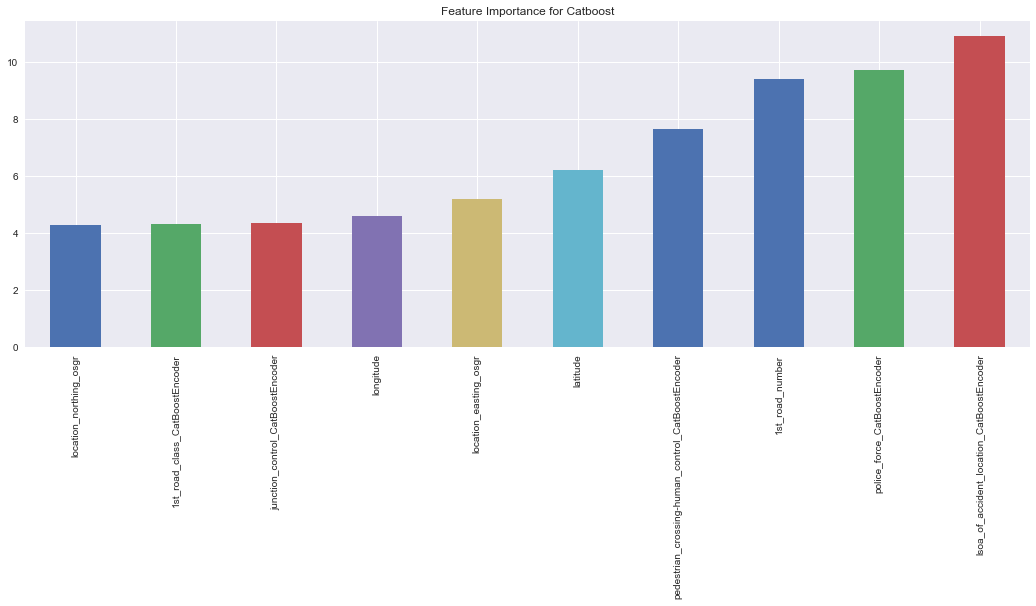

In [32]:
plot_feature_importance(pipe_best_estimator[:-1].transform(X_tr).columns,pipe_best_estimator.named_steps['cb'].get_feature_importance(),10)

# Feature Differences between train and test

In [33]:
train = df[df['train']==1]
test = df[df['train']==0]
train = train.drop(columns='train')
test = test.drop(columns=['train','target'])

**Kolmogorov-Smirnov** statistic

(K–S test or KS test) is a nonparametric test of the equality of continuous one-dimensional probability distributions that can be used to compare a sample with a reference probability distribution (one-sample K–S test), or to compare two samples (two-sample K–S test).

The idea is to compute the Kolmogorov-Smirnov statistic on 2 samples to test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.  This will allow us to see if there are major changes between a variable in the train and in the test dataset. 

The *KS* statistic test computes the KS statistic and pvalue. If the p value is less than .1 the null hypothesis is rejected. In this case you are sampling values from corresponding columns in test and train data frame and storing their pvalues in the list *Se*. If the p value is less than .1 the null hypothesis is rejected. Columns with pvalues less than 0.1 are added to the list_discarded.

In [35]:
df = df._get_numeric_data()
# Split back
train = df[df['train']==1]
test = df[df['train']==0]
train = train.drop(columns='train')
test = test.drop(columns=['train','target'])


In [36]:
# This tests whether 2 samples are drawn from the same distribution. The distribution is assumed to be continuous.
from scipy.stats import ks_2samp 
from tqdm import tqdm

list_p_value =[]

for i in tqdm(test.columns):
    list_p_value.append(ks_2samp(test[i] ,  train[i])[1])

Se = pd.Series(list_p_value, index = test.columns).sort_values() 
list_discarded = list(Se[Se < .4].index)

100%|██████████| 49/49 [00:01<00:00, 25.31it/s]


In [37]:
pd.DataFrame(Se).rename(columns={0:'p-value'})

,p-value
lsoa_of_accident_location_CatBoostEncoder,2.139876e-124
1st_road_number,6.389100e-118
1st_road_class_CatBoostEncoder,1.198683e-49
urban_or_rural_area_CatBoostEncoder,1.098965e-36
speed_limit,9.283725e-36
police_force_CatBoostEncoder,1.828831e-35
longitude,2.976148e-35
local_authority_highway_CatBoostEncoder,1.744037e-28
local_authority_district_CatBoostEncoder,2.767778e-26
location_northing_osgr,1.554710e-21
